# Options 4: Hedging Options

## Load Packages

In [1]:
using Dates, Distributions

include("jlFiles/printmat.jl")
include("jlFiles/printTable.jl")

println4Ps (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(480,320))
    default(fmt = :svg)
end

# Delta of an Option: A First-Order Approximation of a Change

"Delta hedging" is based on the idea that we can approximate the change in the option price by 

$C_{t+h}-C_{t}\approx\frac{\partial C_{t}}{\partial S}\left(  S_{t+h}-S_{t}\right)$


In the Black-Scholes model, the Delta of a call option is

$\Delta=\frac{\partial C}{\partial S}=e^{-\delta m}\Phi\left(  d_{1}\right),$ 

where $d_1$ is the usual term im Black-Scholes. 

Similarly, the Delta of a put option is 

$\frac{\partial P}{\partial S}=e^{-\delta m}[\Phi\left(  d_{1}\right)-1]$.

The file included in the next cell contains the functions `Φ()` and `OptionBlackSPs()` from the chapter on the Black-Scholes model. 

The subsequent cell defines a function for the $\Delta$ of the Black-Scholes model.

In [3]:
include("jlFiles/OptionsCalculations.jl")

OptionBlackSPs

In [4]:
"""
Calculate the Black-Scholes delta
"""
function OptionDelta(S,K,m,y,σ,δ=0,PutIt=false)
    d1 = ( log(S/K) + (y-δ+0.5*σ^2)*m ) / (σ*sqrt(m))
    d2 = d1 - σ*sqrt(m)
    if PutIt 
        Δ = exp(-δ*m)*(Φ(d1)-1)
    else     
        Δ = exp(-δ*m)*Φ(d1)              
    end    
    return Δ
end

OptionDelta

In [5]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

Δc = OptionDelta(S,K,m,y,σ)               #call
Δp = OptionDelta(S,K,m,y,σ,0,true)        #put
printlnPs("Δ of call and put and the difference: ",[Δc Δp (Δc-Δp)])

Δ of call and put and the difference:      0.598    -0.402     1.000


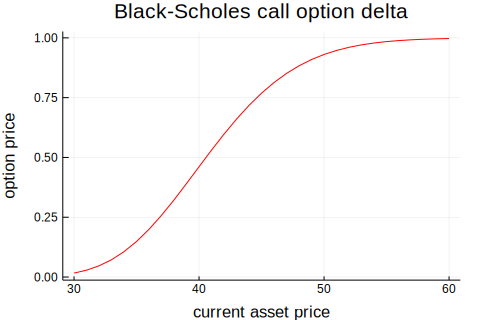

In [6]:
S_range    = 30:60                        #different spot prices      
Δc_S_range = OptionDelta.(S_range,K,m,y,σ)          

p1 = plot(S_range,Δc_S_range,color=:red,legend=false)
title!("Black-Scholes call option delta")
xlabel!("current asset price")
ylabel!("option price")

# Hedging an Option

The example below shows how a delta hedging works for a European call option when the price of the underlying changes (from 42 on day 0 to 43 on day 1). For simplicity, we assume that the Black-Scholes model is a good description of how the option price is set.

In [7]:
(S₀,S₁,K,m,y,σ) = (42,43,42,0.5,0.05,0.2)

C₀ = OptionBlackSPs(S₀,K,m,y,σ)   #option price at S₀
Δ₀ = OptionDelta(S₀,K,m,y,σ)      #Delta at S₀
M₀ = C₀ - Δ₀*S₀                    #on money market account

C₁ = OptionBlackSPs(S₁,K,m-1/252,y,σ)   #option price at S₁ (it's one day later) 
dC = C₁ - C₀                      #change of option value         
dV = Δ₀*(S₁-S₀) - (C₁-C₀)           #change of hedge portfolio value

xy = [S₀,Δ₀,C₀,M₀,S₁,C₁,dC,dV]
printTable(xy,[" "],["S₀","Δ₀","C₀","M₀","S₁","C₁","dC","dV"])


printstyled("\nV changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps",color=:blue)

            
S₀    42.000
Δ₀     0.598
C₀     2.893
M₀   -22.212
S₁    43.000
C₁     3.509
dC     0.616
dV    -0.018


V changes much less in value than the option (abs(dV) < abs(dC)): 
the hedge helps